<a href="https://colab.research.google.com/github/fildahgwen/domain_generation_a_detection/blob/main/DGA_Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
RANDOM_STATE = 42

In [28]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

# **EDA**

In [29]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [30]:
data = pd.read_csv('DGA_new.csv')
data.head()

,Domain,Family
0,jkybwgxpfr.com,DGA
1,scxjfe.com,DGA
2,xmkrwnrrtes.com,DGA
3,cagqhss.net,DGA
4,vljdew.com,DGA


In [31]:
df1 = data.loc[data['Family'] == "DGA"][0:100000]
df2 = data.loc[data['Family'] == "Benign"][0:100000]
df = pd.concat([df1,df2])

In [32]:
df.shape

(200000, 2)

In [33]:
df.describe()

,Domain,Family
count,200000,200000
unique,200000,2
top,jkybwgxpfr.com,DGA
freq,1,100000


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 1399620
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Domain  200000 non-null  object
 1   Family  200000 non-null  object
dtypes: object(2)
memory usage: 4.6+ MB


# **Data Visualization**

In [35]:
benign_count = df['Family'].value_counts()
pd.DataFrame(benign_count)

,Family
DGA,100000
Benign,100000


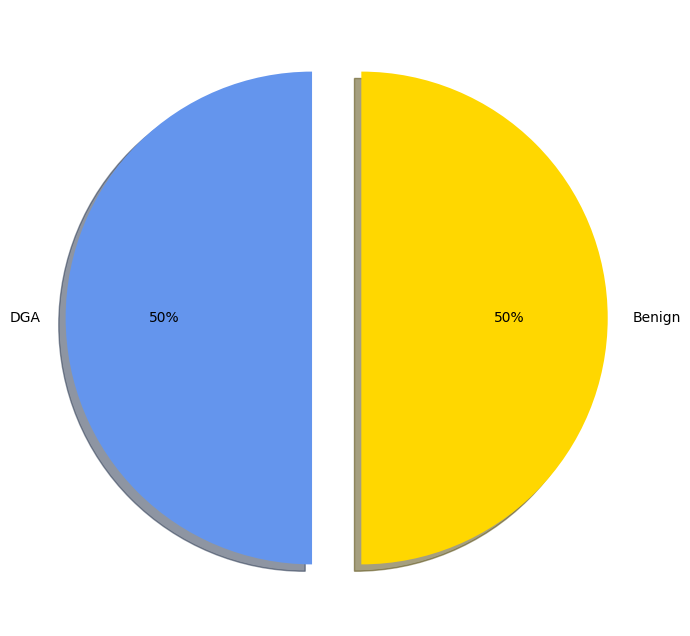

In [36]:
plt.figure(figsize=(15,8));
plt.pie(benign_count.values, labels=benign_count.keys(), autopct='%.0f%%',colors=['cornflowerblue', 'gold'],startangle = 90, shadow = True,explode=(0.1,0.1))
plt.show()

# **Model Development**

In [37]:
!pip install --upgrade pip

import keras as tf

In [38]:

import keras as tf

In [39]:
# Import Libraries to Model Development

!pip install Keras-Preprocessing

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint

In [40]:
# Data and Target
X = df['Domain']
y = df['Family']

In [41]:
# one-hot-encoder
from sklearn.preprocessing import OneHotEncoder
y2 = np.array(y).reshape(-1, 1)

hot_encode = OneHotEncoder(sparse=False)
hot_encode = hot_encode.fit(y2)
y_new = hot_encode.transform(y2)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [42]:
y_new.shape

(200000, 2)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size=0.2, random_state=RANDOM_STATE)

In [44]:
print(X_train.shape)
print(y_train.shape)

(160000,)
(160000, 2)


In [45]:
# Tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X_train)

In [46]:
# create Data
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

max_length = 20
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test  = pad_sequences(X_test, maxlen=max_length, padding='post')

In [47]:
# Lets see how data after tolenization
print(X_train[1:5])
print(y_train[1:5])

[[19  5 27 24  4 18  5 17 18 10 27  6 12 26  8 16  1  2 11  0]
 [ 9 15 12  3 11  8  9  3  4 10  5 14  1  4  3  6  0  0  0  0]
 [ 3 17  5 14 12  2 13 10 12  1  5 22  5 13  7  9  1  7  2  8]
 [15 12  3 13  1 10  7 19 12  5  1 18  2 17  2 24  1  4  3  6]]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


Callbacks

In [48]:
# Tensorboard callback
tensor_board = tf.keras.callbacks.TensorBoard(log_dir="./logs")

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Callabck to save Best model
save_best_model_checkpoint = ModelCheckpoint('models_binary/model-{epoch:03d}.h5',monitor='val_loss',save_best_only=True,mode='auto')

## **Build Model**
LSTM model

In [49]:
model = Sequential()
model.add(Embedding(input_dim = len(tokenizer.word_index)+1, output_dim=128, input_length = max_length))
model.add(LSTM(units = 128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units = len(benign_count), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 128)           4992      
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 136834 (534.51 KB)
Trainable params: 136834 (534.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
# train Model
EPOCHS = 50
BATCH_SIZE = 8198
VALIDATION_SPLIT = 0.2

history = model.fit(X_train, y_train, validation_split = VALIDATION_SPLIT, epochs=EPOCHS, callbacks=[early_stopping,tensor_board,save_best_model_checkpoint],batch_size = BATCH_SIZE)

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 0.6077 - accuracy: 0.7720

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 13s 288ms/step - loss: 0.6077 - accuracy: 0.7720 - val_loss: 0.3503 - val_accuracy: 0.8486
Epoch 2/50
16/16 [==============================] - 3s 159ms/step - loss: 0.2470 - accuracy: 0.9017 - val_loss: 0.1665 - val_accuracy: 0.9292
Epoch 3/50
16/16 [==============================] - 3s 160ms/step - loss: 0.1476 - accuracy: 0.9355 - val_loss: 0.1289 - val_accuracy: 0.9415
Epoch 4/50
16/16 [==============================] - 2s 157ms/step - loss: 0.1266 - accuracy: 0.9428 - val_loss: 0.1126 - val_accuracy: 0.9513
Epoch 5/50
16/16 [==============================] - 2s 155ms/step - loss: 0.1119 - accuracy: 0.9511 - val_loss: 0.0985 - val_accuracy: 0.9587
Epoch 6/50
16/16 [==============================] - 4s 248ms/step - loss: 0.1001 - accuracy: 0.9567 - val_loss: 0.0920 - val_accuracy: 0.9612
Epoch 7/50
16/16 [==============================] - 3s 163ms/step - loss: 0.0937 - accuracy: 0.9593 - val_loss: 0.0854 - val_accuracy: 0.9646
Epoch 8/50
16/16

In [51]:
model.save("models_binary/DGA_Binary_Model.h5")

In [26]:
%load_ext tensorboard

In [52]:
%tensorboard --logdir './logs'

<IPython.core.display.Javascript object>

In [53]:
model.evaluate(X_test, y_test)

1250/1250 [==============================] - 12s 9ms/step - loss: 0.0399 - accuracy: 0.9840


[0.039919715374708176, 0.9839500188827515]

In [54]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.figure(figsize=(8,6))
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))
    plt.grid()
    plt.legend()

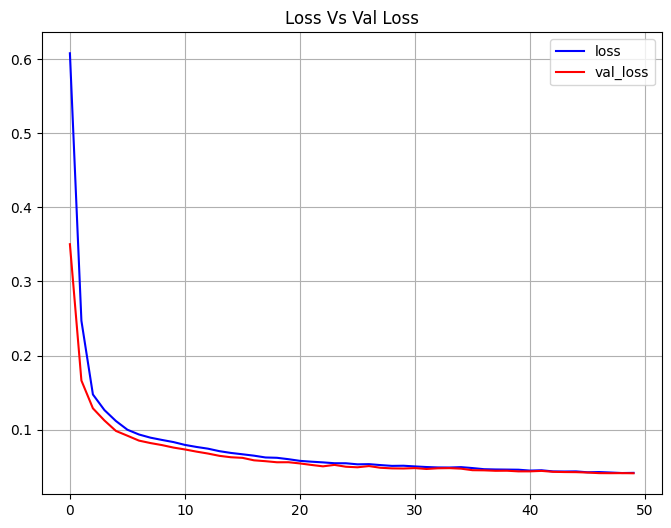

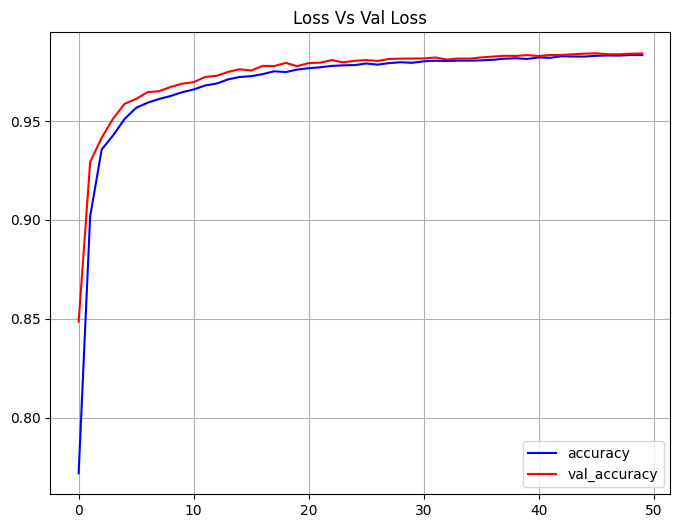

In [55]:
plot_metric(history,'loss','val_loss','Loss Vs Val Loss')
plot_metric(history,'accuracy','val_accuracy','Loss Vs Val Loss')

## Evaluate the Model

In [56]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [57]:
def calculate_accuray_matrix(actual,predicted):
  f1 = f1_score(actual, predicted, average='micro')
  recall = recall_score(actual, predicted, average='micro')
  precision = precision_score(actual, predicted, average='micro')
  accuracy = accuracy_score(actual, predicted)

  print(f'Accuracy : {accuracy}')
  print(f'F1 score : {f1}')
  print(f'Recall : {recall}')
  print(f'precision : {precision}')

def confusion_matrix_plot(actual,predicted):
  columns = benign_count.keys()
  cm = confusion_matrix(actual, predicted)
  df_cm = pd.DataFrame(cm, index=columns, columns=columns)
  plt.figure(figsize=(16,12))
  sns.heatmap(df_cm, annot=True);

### **Accuracies on Train Data**

In [58]:
train_predictions = model.predict(X_train)
train_predictions = np.argmax(train_predictions, axis=1)
actual_train_targets = np.argmax(y_train, axis=1)

print(f'Predicted Train Labels : {train_predictions[:10]}')
print(f'Actual Train Labels : {actual_train_targets[:10]}')

calculate_accuray_matrix(train_predictions,actual_train_targets)

5000/5000 [==============================] - 48s 10ms/step
Predicted Train Labels : [0 1 0 0 0 1 1 0 0 1]
Actual Train Labels : [0 1 0 0 0 1 1 0 0 1]
Accuracy : 0.9847875
F1 score : 0.9847875
Recall : 0.9847875
precision : 0.9847875


In [59]:
# Classification Report for Train Data
print(classification_report(actual_train_targets, train_predictions))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     79993
           1       0.98      0.99      0.98     80007

    accuracy                           0.98    160000
   macro avg       0.98      0.98      0.98    160000
weighted avg       0.98      0.98      0.98    160000



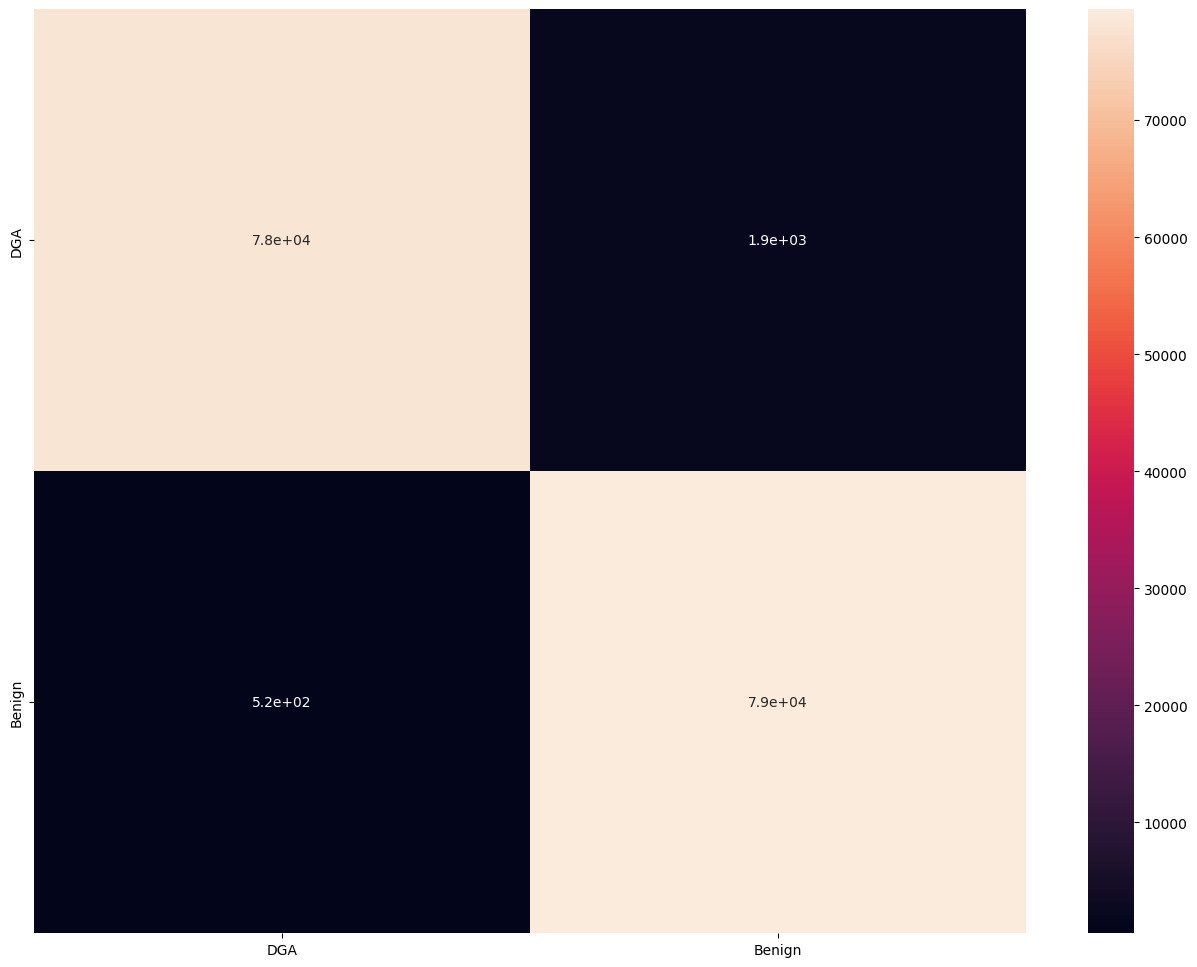

In [60]:
# confusion Matrix for train data
confusion_matrix_plot(actual_train_targets, train_predictions)

### **Accuracies on Test Data**

In [61]:
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)
actual_test_targets = np.argmax(y_test, axis=1)

print(f'Predicted Test Labels : {test_predictions[:10]}')
print(f'Actual Test Labels : {actual_test_targets[:10]}')

calculate_accuray_matrix(test_predictions,actual_test_targets)

1250/1250 [==============================] - 11s 9ms/step
Predicted Test Labels : [0 1 0 1 1 1 0 0 0 1]
Actual Test Labels : [0 1 0 1 1 1 0 0 0 1]
Accuracy : 0.98395
F1 score : 0.98395
Recall : 0.98395
precision : 0.98395


In [62]:
# Classification Report for Test Data
print(classification_report(actual_test_targets, test_predictions))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     20007
           1       0.98      0.99      0.98     19993

    accuracy                           0.98     40000
   macro avg       0.98      0.98      0.98     40000
weighted avg       0.98      0.98      0.98     40000



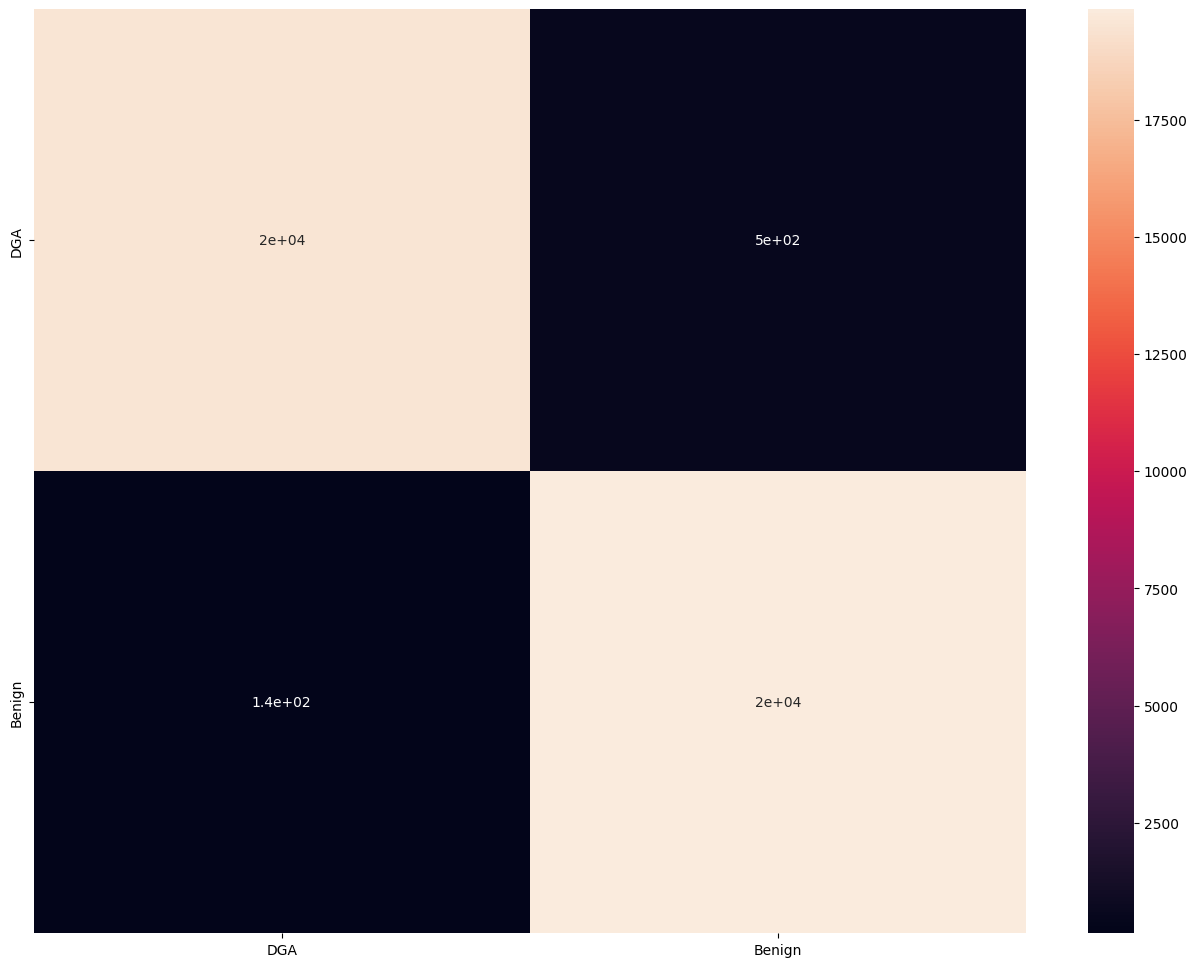

In [63]:
# confusion Matrix for test data
confusion_matrix_plot(actual_test_targets, test_predictions)

## **Predictions on New Data**

In [64]:

test_word = 'xkkumnnbpr.com'
test_word = pd.Series(test_word)
test_word = tokenizer.texts_to_sequences(test_word)
test_word = pad_sequences(test_word, maxlen = max_length , padding='post')

test_predictions = model.predict(test_word)
#test_predictions = np.argmax(test_predictions, axis=1)
print(test_predictions)
print(hot_encode.inverse_transform(test_predictions))

1/1 [==============================] - 0s 232ms/step
[[0.02471876 0.9752813 ]]
[['DGA']]


In [65]:
def preprocess_function(text):
  max_length = 20
  if text[:3] == "www":
    text = text[4:]

  encode_text = pd.Series(text)
  encode_text = tokenizer.texts_to_sequences(encode_text)
  preprocess_text = pad_sequences(encode_text, maxlen = max_length , padding='post')
  return preprocess_text

In [66]:
test_website = 'www.xkkumnnbpr.com'
preprocess_text =  preprocess_function(test_website)

prediction_class = model.predict(preprocess_text)
prediction = hot_encode.inverse_transform(prediction_class)

print(f'The Website : {test_website} is {prediction[0][0]}')

1/1 [==============================] - 0s 25ms/step
The Website : www.xkkumnnbpr.com is DGA


### **Save data for future prediction**

In [67]:
import os
import joblib
import io
import json

save_dir = r'utils_DGA_BINARY'
if not os.path.exists(save_dir):
  os.makedirs(save_dir)

# save tokenizer
tokenizer_json = tokenizer.to_json()
with io.open(save_dir+'/Binary_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

# save hot-encoder
joblib.dump(hot_encode,save_dir+'/hot_encode.sav')

['utils_DGA_BINARY/hot_encode.sav']